# Homework 3 Fisherface

## Instructions

Answer the questions and upload your answers to courseville. Answers can be in Thai or English. Answers can be either typed or handwritten and scanned. the assignment is divided into several small tasks. Each task is weighted equally
(marked with T). For this assignment, each task is awarded 0.4 points. There are also optional tasks (marked with OT) counts for 0.3 points each

## Hello Soft Clustering (GMM)

Recall from HW1 we did K-means clustering. Fitting a GMM on a set of
points can be considered as another method to do clustering but now with soft assignments.

Consider the same set of points we used in HW1

| x   |  y   |
| --- | ---  |
| 1   |  2   |
| 3   |  3   |
| 2   |  2   |
| 8   |  8   |
| 6   |  6   |
| 7   |  7   |
| -3  |  -3  |
| -2  |  -4  |
| -7  |  -7  |

In class, we showed that we could fit a GMM on 1-dimensional data by using Expectation Maximization (EM). The algorithm for doing EM on N-dimensional GMM is very similar. The exact algorithm is as follows:

**Initialization**: Initialize the mixture weights, $\phi = {m_j }$, where j is the mixture number, means of each Gaussian, $\vec{\mu_j}$ (now a vector of N dimensions),
and covariance matrices of each Gaussian, $\Sigma_j$

**Expectation**: Find the soft assignments for each data point $w_{n,j}$ where n corresponds to the sample index.

\begin{aligned}
w_{n,j} = \frac{p(x_n;\vec{\mu_j}, \Sigma_j)m_j}{\Sigma_jp(x_n;\vec{\mu_j}, \Sigma_j)m_j}
\end{aligned}

$w_{n,j}$ means the probability that data point n comes from Gaussian number j

**Maximization**: Update the model parameters, $\phi$, $\vec{\mu_j}$ , $\Sigma_j$ 

\begin{aligned}
m_j &= \frac{1}{N}\Sigma_n w_{n,j} \\
\vec{\mu_j} &= \frac{\Sigma_n w_{n,j} \vec{x_n}}{\Sigma_n w_{n,j}} \\
\Sigma_j &= \frac{\Sigma_n w_{n,j}(\vec{x_n} - \vec{\mu_j})(\vec{x_n} - \vec{\mu_j})^T }{\Sigma_n w_{n,j}}
\end{aligned}

The above equation is used for full covariance matrices. For our small toy example, we will use diagonal covariance matrices, which can be acquired by setting the off-diagonal values to zero. In other words, $\Sigma_{(i,j)}$ = 0, for $i \neq j$.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats
import pandas as pd
import math
from skimage import img_as_float
from tabulate import tabulate

## T1

Using 3 mixtures, initialize your Gaussian with means (3,3), (2,2),
and (-3,-3), and standard Covariance, I, the identity matrix. Use equal mixture weights as the initial weights. Repeat three iterations of EM. Write down $w_{n,j}$ ,$m_j$ , $\vec{\mu_j}$ ,$\Sigma_j$ for each EM iteration. (You may do the calculations by hand
or write code to do so)

In [59]:
class GaussianMixtureModel:
  def __init__(self, points: np.ndarray, mixture_number: int, init_means: np.ndarray):
    self.points = np.array(points, dtype=np.float64)
    self.mixture_number = mixture_number
    self.means = np.array(init_means, dtype=np.float64)
    self.covariance = np.array([np.identity(len(self.points[0])) for _ in range(self.mixture_number)])
    self.weights = np.ones(mixture_number) / mixture_number
    self.loglikelihood = []
    self.iteration = 0
  
  # Define expectation step
  def expectation(self):
    self.prob = np.zeros((len(self.points), self.mixture_number))
    for j in range(self.mixture_number):
      self.prob[:, j] = self.weights[j] * stats.multivariate_normal.pdf(self.points, self.means[j], self.covariance[j])
    self.prob = self.prob / np.sum(self.prob, axis=1, keepdims=True)
    return self.prob
  
  # Define maximization step
  def maximization(self):
    self.weights = np.sum(self.prob, axis=0) / len(self.points)
    for j in range(self.mixture_number):
      divider = np.sum(self.prob[:, j], axis=0)
      self.means[j] = np.dot(self.prob[:, j], self.points) / divider
    for j in range(self.mixture_number):
      divider = np.sum(self.prob[:, j], axis=0)
      error = self.points - self.means[j]
      result = np.dot(error.T, (self.prob[:, j, np.newaxis] * error))
      self.covariance[j] = result / divider
      self.covariance[j][0][1] = self.covariance[j][1][0] = 0
    
    return self.weights, self.means, self.covariance

  # Define run iterations function
  def iterate(self):
    self.expectation()
    self.maximization()
    self.loglikelihood.append(self.find_loglikelihood())
    self.iteration += 1

  # Define describe function
  def describe(self, all=False):
    if(all): print(f'Number of points: {len(self.points)}')
    if(all): print(f'Number of mixture components: {self.mixture_number}')
    means = [[f'j = {j}'] + [m for m in self.means[j]] for j in range(self.mixture_number)]
    print(tabulate(means, [f"iteration {self.iteration}", "mean x", "mean y"], tablefmt = "github"))
    print()
    covariance = [[f'j = {j}', self.covariance[j][0][0], self.covariance[j][1][1]] for j in range(self.mixture_number)]
    print(tabulate(covariance, [f"iteration {self.iteration}", "var x", "var y"], tablefmt = "github"))
    print()
    weights = [[f'j = {j}', self.weights[j]] for j in range(self.mixture_number)]
    print(tabulate(weights, [f"iteration {self.iteration}", "weight"], tablefmt = "github"))

  # Define plot function
  def plot(self, title: str, colors: list = None):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.scatter(self.points[:, 0], self.points[:, 1])
    if colors is None:
      colors = ["blue" for i in range(self.mixture_number)]
    for j in range(self.mixture_number):
      x = np.linspace(self.means[j][0] - 3 * math.sqrt(self.covariance[j][0][0]), self.means[j][0] + 3 * math.sqrt(self.covariance[j][0][0]), 100)
      y = np.linspace(self.means[j][1] - 3 * math.sqrt(self.covariance[j][1][1]), self.means[j][1] + 3 * math.sqrt(self.covariance[j][1][1]), 100)
      X, Y = np.meshgrid(x, y)
      pos = np.empty(X.shape + (2,))
      pos[:, :, 0] = X; pos[:, :, 1] = Y
      plt.contour(X, Y, stats.multivariate_normal.pdf(pos, self.means[j], self.covariance[j]), colors=colors[j])
    plt.show()

  # Define plot log likelihood function
  def find_loglikelihood(self):
    l = 0
    for i in range(len(self.points)):
      acc = 0;
      for j in range(self.mixture_number):
        acc += self.weights[j] * stats.multivariate_normal.pdf(self.points[i], self.means[j], self.covariance[j])
      l += math.log(acc)
    return l

  def plot_loglikelihood(self):
    plt.plot(range(len(self.loglikelihood)), self.loglikelihood)
    plt.show()

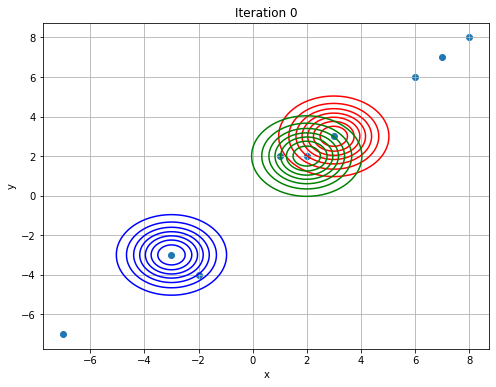

| iteration 1   |   mean x |   mean y |
|---------------|----------|----------|
| j = 0         |  5.78993 |  5.81887 |
| j = 1         |  1.67718 |  2.14523 |
| j = 2         | -4       | -4.66667 |

| iteration 1   |    var x |    var y |
|---------------|----------|----------|
| j = 0         | 4.53619  | 4.28701  |
| j = 1         | 0.516456 | 0.131526 |
| j = 2         | 4.66667  | 2.88889  |

| iteration 1   |   weight |
|---------------|----------|
| j = 0         | 0.457572 |
| j = 1         | 0.209094 |
| j = 2         | 0.333333 |


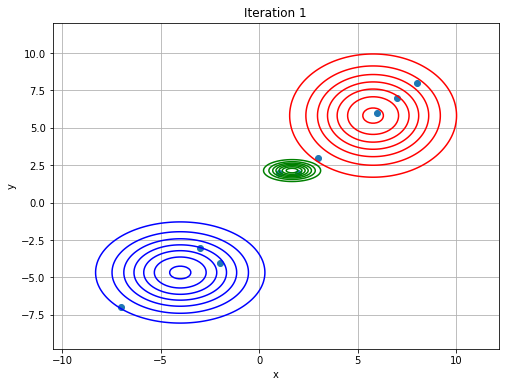

| iteration 2   |   mean x |   mean y |
|---------------|----------|----------|
| j = 0         |  6.27176 |  6.27263 |
| j = 1         |  1.72092 |  2.14765 |
| j = 2         | -3.99999 | -4.66665 |

| iteration 2   |    var x |    var y |
|---------------|----------|----------|
| j = 0         | 2.94673  | 2.93847  |
| j = 1         | 0.496493 | 0.125848 |
| j = 2         | 4.66673  | 2.889    |

| iteration 2   |   weight |
|---------------|----------|
| j = 0         | 0.407116 |
| j = 1         | 0.25955  |
| j = 2         | 0.333334 |


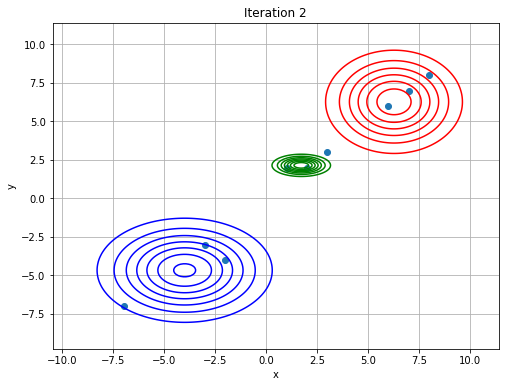

| iteration 3   |   mean x |   mean y |
|---------------|----------|----------|
| j = 0         |  6.69626 |  6.69629 |
| j = 1         |  1.91071 |  2.27383 |
| j = 2         | -3.99999 | -4.66665 |

| iteration 3   |    var x |    var y |
|---------------|----------|----------|
| j = 0         | 1.73961  | 1.7393   |
| j = 1         | 0.628984 | 0.198849 |
| j = 2         | 4.66673  | 2.889    |

| iteration 3   |   weight |
|---------------|----------|
| j = 0         | 0.360709 |
| j = 1         | 0.305957 |
| j = 2         | 0.333334 |


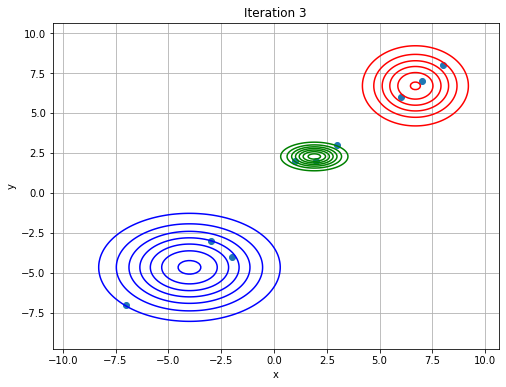

In [60]:
points = np.array([
  [1, 2],
  [3, 3],
  [2, 2],
  [8, 8],
  [6, 6],
  [7, 7],
  [-3, -3],
  [-2, -4],
  [-7, -7]
], dtype=np.float64)
means = np.array([[3, 3], [2, 2], [-3, -3]], dtype=np.float64)
colors = ["red", "green", "blue"]
iteration = 3
mixture = 3

gmm = GaussianMixtureModel(points, mixture, means)
gmm.plot("Iteration 0", colors)

loglikelihood = []

for i in range(iteration):
  gmm.iterate()
  gmm.describe()
  gmm.plot("Iteration " + str(i + 1), colors)

## T2

Plot the log likelihood of the model given the data after each EM step. In other words, plot log $\Pi_np(\vec{x_n}|\phi,\vec{\mu}, \Sigma)$. Does it goes up every iteration just
as we learned in class?

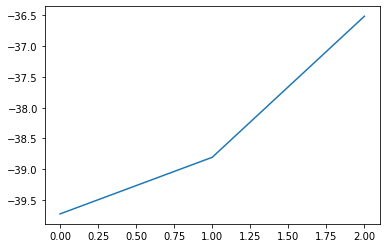

In [61]:
gmm.plot_loglikelihood()

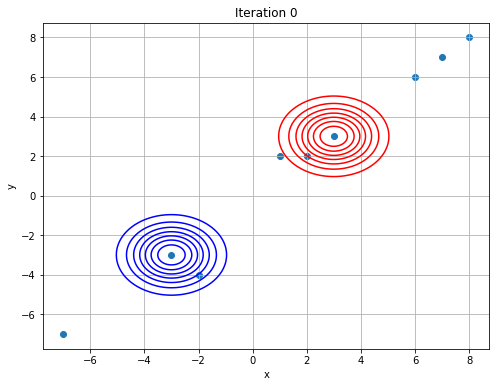

| iteration 1   |   mean x |   mean y |
|---------------|----------|----------|
| j = 0         |      4.5 |  4.66667 |
| j = 1         |     -4   | -4.66667 |

| iteration 1   |   var x |   var y |
|---------------|---------|---------|
| j = 0         | 6.91667 | 5.88889 |
| j = 1         | 4.66667 | 2.88889 |

| iteration 1   |   weight |
|---------------|----------|
| j = 0         | 0.666667 |
| j = 1         | 0.333333 |


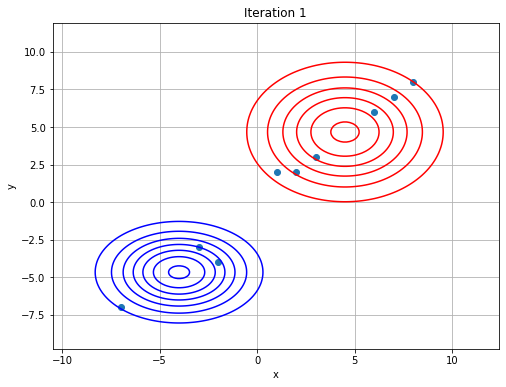

| iteration 2   |   mean x |   mean y |
|---------------|----------|----------|
| j = 0         |  4.49961 |  4.6662  |
| j = 1         | -3.99993 | -4.66651 |

| iteration 2   |   var x |   var y |
|---------------|---------|---------|
| j = 0         | 6.91945 | 5.89275 |
| j = 1         | 4.66807 | 2.89103 |

| iteration 2   |   weight |
|---------------|----------|
| j = 0         | 0.666694 |
| j = 1         | 0.333306 |


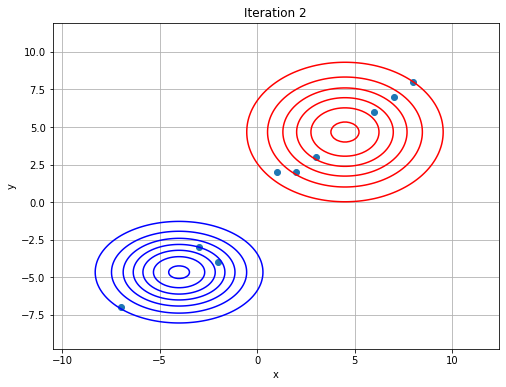

| iteration 3   |   mean x |   mean y |
|---------------|----------|----------|
| j = 0         |  4.49961 |  4.6662  |
| j = 1         | -3.99993 | -4.66651 |

| iteration 3   |   var x |   var y |
|---------------|---------|---------|
| j = 0         | 6.91946 | 5.89277 |
| j = 1         | 4.66808 | 2.89105 |

| iteration 3   |   weight |
|---------------|----------|
| j = 0         | 0.666695 |
| j = 1         | 0.333305 |


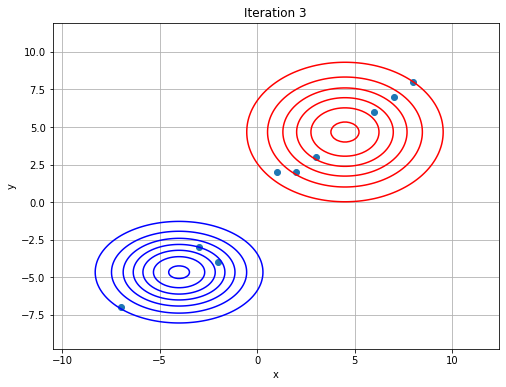

In [62]:
points = np.array([
  [1, 2],
  [3, 3],
  [2, 2],
  [8, 8],
  [6, 6],
  [7, 7],
  [-3, -3],
  [-2, -4],
  [-7, -7]
], dtype=np.float64)
means = np.array([[3, 3], [-3, -3]], dtype=np.float64)
colors = ["red", "blue"]
iteration = 3
mixture = 2

gmm = GaussianMixtureModel(points, mixture, means)
gmm.plot("Iteration 0", colors)

loglikelihood = []

for i in range(iteration):
  gmm.iterate()
  gmm.describe()
  gmm.plot("Iteration " + str(i + 1), colors)

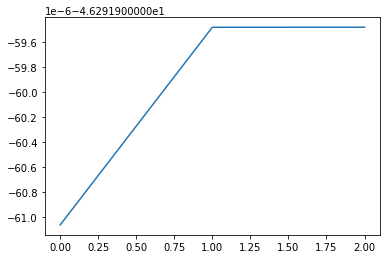

In [63]:
gmm.plot_loglikelihood()

## Answer 

แบบ XXX ดีกว่า

# The face database

For the rest of the homework we will work on face verification (Given a face, say whether it is person A or not). Face verification is quite related to face recognition (Given a face, say who it is). Face verification is a binary classification task, while face recognition is a multi-class problem.

Download the file `facedata.mat` from github. You can load the data by

```py
import scipy.io
data = scipy.io.loadmat(<path to facedata.mat>)
```

data is a dictionary with key value pairs. The data you want to use can be accessed by using `facedata` as the key.

```py
# face data is a 2-dimensional array with size 40x10
print data["facedata"].shape
# Each data is indexed by i and j
# where i is the person index
# j is the index of the pose
# In other words, there are 40 people in the database.
# There are 10 images per person.
print data["facedata"][0,0]
# Each image is a 56 by 46 image
print data["facedata"][0,0].shape
# You can see the image by using the imshow in matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(data["facedata"][0,0],cmap="gray")
plt.show()
```

## Working with images
Each pixel in an image is usually represented by a 8-bit unsigned integer (values from 0 to 255). In order to easily work on images, we usually convert them to floats or doubles using the following command.

```py
from skimage import img_as_float
xf = {}
xf[0,0] = img_as_float(data["facedata"][0,0])
print xf[0,0]
```

`img_as_float` scales 0-255 to 0-1. You can still show the image using the same imshow command.

Note that the index of a 2D image starts from the upper left corner of the image. The first dimension goes downwards, while the second dimension goes to the right (think of it as a matrix). To understand what this means, try the following code.

```py
plt.imshow(xf[0,0],cmap="gray")
plt.show()
x_temp = xf[0,0]
x_temp[0:5,0:10] = 1
# In float format, 1 is white
plt.imshow(x_temp,cmap="gray")
plt.show()
```

## The similarity matrix
Consider a set of N data points, a similarity matrix $S$ is a matrix where $S_{i,j}$ is the distance between the ith and the jth data point. A similarity matrix can be very useful for analyzing the data and its distribution. Since a similarity matrix can also be considered as an image, you can also show it as an image to see the pattern in the data.

But how do we define similarity? How can we quantify whether image A is closer to B than image C? One way is to treat each pixel in image as an element in a vector (you may find the function `numpy.reshape()` useful). Then, compare the two vectors using Euclidean distance.

Euclidean distance between vector x and y is defined as:

\begin{aligned}
Euclidean_distance = \sqrt{\Sigma_d(x_d-y_d)^2} 
\end{aligned}

where $d$ refers to the index of the dimension

In [64]:
import scipy.io
data = scipy.io.loadmat("./facedata.mat")

In [65]:
xf = {}
people = data["facedata"].shape[0]
faces = data["facedata"].shape[1]
for i in range(people):
  for j in range(faces):
    xf[i, j] = img_as_float(data["facedata"][i, j])

## T5

What is the Euclidean distance between `xf[0,0]` and `xf[0,1]`? What
is the Euclidean distance between `xf[0,0]` and `xf[1,0]`? Does the numbers make sense? Do you think these numbers will be useful for face verification?

In [66]:
# Define euclidean distance function
def euclidean_distance(image_x: np.ndarray, image_y: np.ndarray) -> int:
  x, y = image_x.reshape(-1), image_y.reshape(-1)
  diff = x - y 
  return np.sqrt(np.dot(diff, diff))

Compare xf[0,0] and xf[0,1] 10.037616294165492
Compare xf[0,0] and xf[1,0] 8.173295099737281



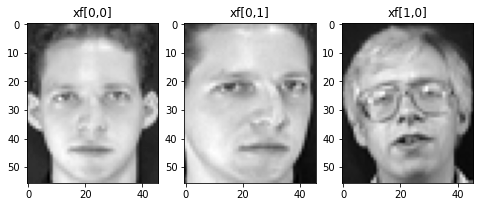

In [67]:
print("Compare xf[0,0] and xf[0,1]", euclidean_distance(xf[0,0], xf[0,1]))
print("Compare xf[0,0] and xf[1,0]", euclidean_distance(xf[0,0], xf[1,0]))
fig, axs = plt.subplots(figsize=(8, 6), ncols=3)
axs[0].imshow(xf[0,0], cmap="gray")
axs[0].set_title("xf[0,0]")
axs[1].imshow(xf[0,1], cmap="gray")
axs[1].set_title("xf[0,1]")
axs[2].imshow(xf[1,0], cmap="gray")
axs[2].set_title("xf[1,0]")
print()

## Answer

euclidean distance จะมีประโยชน์สำหรับการ verifty ว่ารูปที่เป็น input ตรงกับรูปในฐานข้อมูลมากแค่ไหน ยิ่งน้อยแปลว่ายิ่งเหมือน

As we continue our exercise, we will refine our feature vectors so that the Euclidean distance between two images can be used in a face verification system.

We define the similarity matrix, A, as a matrix whose elements $A_{i,j}$ is the Euclidean distance between data sample i from list T and data sample j from list D, where list T, D are lists of data samples.

## T6

Write a function that takes in a set of feature vectors T and a set of feature vectors D, and then output the similarity matrix A. Show the matrix as an image. Use the feature vectors from the first 3 images from all 40 people for list T (in order x[0,0],x[0,1],x[0,2],x[1,0],x[1,1],...x[39,2]). Use the feature vectors from the remaining 7 images from all 40 people for list D (in order x[0,3],x[0,4],x[0,5],x[1,6],x[0,7],x[0,8],x[0,9],x[1,3],x[1,4]...x[39,9]). We will treat T as our training images and D as our testing images

In [68]:
def distance_matrix(T: list, D:list):
  return np.array([[euclidean_distance(T[i], D[j]) for j in range(len(D))] for i in range(len(T))])

In [69]:
T, D = [], []
for i in range(people):
  for j in range(0, 3):
    T.append(xf[i, j])
  for j in range(3, faces):
    D.append(xf[i, j])
T, D = np.array(T), np.array(D)

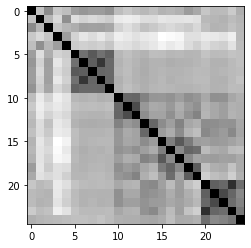

In [70]:
example = [xf[i, j] for i in range(5) for j in range(5)]
m = distance_matrix(example, example)
plt.imshow(m, cmap="gray")
plt.show()

## T7 

From the example similarity matrix above, what does the black square
between [5:10,5:10] suggest about the pictures from person number 2? What do the patterns from person number 1 say about the images from person 1

## Answer

Black square [5:10, 5:10] หมายถึงในช่วงนั้น T[i] กับ D[j] มีความเหมือนกันมาก ๆ (ดำสนิทคือเหมือน 100%)  

นั้นหมายความว่า รูปของ person 2 ในแต่ท่าทางมีความเหมือนกันมาก

ส่วนของ person 1 [0:5, 0:5] จะหมายความแต่ละท่าทางของ person 1 ไม่ค่อยเหมือนกันเท่าไร

**A simple face verification system**

In our simple face verification system, given a test image, we want to test if that image comes from person A or not. We will compare the test image against the three training images from person A we have. If the minimum distance (between the three training images) is below a threshold, t, we say that the test image is person A.

## T8

Write a function that takes in the similarity matrix created from the
previous part, and a threshold t as inputs. The outputs of the function are the true positive rate and the false alarm rate of the face verification task (280 Test images, tested on 40 people, a total of 11200 testing per threshold). What is the true positive rate and the false alarm rate for t = 10?

In [90]:
class ConfusionMatrix:
  def __init__(self, T: list, D: list, images_T: int, images_D: int):
    self.T = T
    self.D = D
    self.images = {
      "T": images_T,
      "D": images_D
    }
    self.people = len(T) // images_T

  def find_actual(self):
    actual = np.zeros((len(self.T) // self.images["T"], len(self.D)))
    iT, iD = self.images["T"], self.images["D"]
    for i in range(self.people):
      actual[i, i*iD:i*iD+iD] = True
    return actual

  def find_predict(self):
    diff_matrix = distance_matrix(self.T, self.D)
    return diff_matrix

  def decide_predict(self, predict, threshold=10):
    predict = predict.reshape((self.people, self.images["T"], -1))
    predict = np.min(predict, axis=1)
    return (predict < threshold).astype(bool)
  
  def report(self, predict=None, actual=None, threshold=10):
    if actual is None:
      actual = self.find_actual().astype(bool)
    if predict is None:
      predict = self.find_predict()
    predict = self.decide_predict(predict, threshold)
    true_positive = np.sum(predict & actual)
    false_positive = np.sum(predict & ~actual)
    false_negative = np.sum(~predict & actual)
    true_negative = np.sum(~predict & ~actual)
    true_positive_rate = true_positive / (true_positive + false_negative)
    false_positive_rate = false_positive / (false_positive + true_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    false_negative_rate = false_negative / (false_negative + true_positive)
    return {
      "true_positive_rate": true_positive_rate,
      "false_positive_rate": false_positive_rate,
      "true_negative_rate": true_negative_rate,
      "false_negative_rate": false_negative_rate
    }

  def get_thresholds(self, diff_matrix):
    min_threshold = np.min(diff_matrix)
    max_threshold = np.max(diff_matrix)
    thresholds = np.linspace(min_threshold, max_threshold, 1000)
    return thresholds

  def plot_roc(self, show=True, label=None):
    diff_matrix = distance_matrix(self.T, self.D)
    thresholds = self.get_thresholds(diff_matrix)
    actual = self.find_actual().astype(bool)
    tprs, fprs = [], []
    for t in thresholds:
      info = self.report(predict=diff_matrix, actual=actual, threshold=t)
      tprs.append(info["true_positive_rate"])
      fprs.append(info["false_positive_rate"])
    plt.plot(fprs, tprs, label=label)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    if show: plt.show()

  def find_infos(self):
    diff_matrix = distance_matrix(self.T, self.D)
    thresholds = self.get_thresholds(diff_matrix)
    actual = self.find_actual().astype(bool)
    infos = []
    for t in thresholds:
      info = self.report(predict=diff_matrix, actual=actual, threshold=t)
      infos.append(info)
    return infos
        

In [91]:
confusionMatrix = ConfusionMatrix(T, D, 3, 7)
tabulate(confusionMatrix.report().items(), headers=["Metric", "Value"], tablefmt = "html") 

Metric,Value
true_positive_rate,0.996429
false_positive_rate,0.45641
true_negative_rate,0.54359
false_negative_rate,0.00357143


## T9

Plot the RoC curve for this simple verification system. What should
be the minimum threshold to generate the RoC curve? What should be the maximum threshold? Your RoC should be generated from at least 1000 threshold levels equally spaced between the minimum and the maximum. (You should write a function for this).

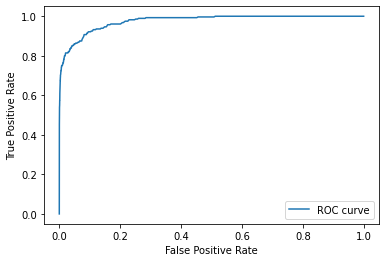

In [93]:
confusionMatrix.plot_roc(label="ROC curve")

## T10

What is the EER (Equal Error Rate)? What is the recall rate at 0.1%
false alarm rate? (Write this in the same function as the previous question)

In [74]:
infos = confusionMatrix.find_infos()
fprs = np.array([info["false_positive_rate"] for info in infos])
fnrs = np.array([info["false_negative_rate"] for info in infos])

index = np.argmin(np.abs(fprs - fnrs))
eer = fprs[index]
print("EER:", eer)

print("-------------")
fprs_pos = np.argmax(fprs[fprs <= 0.001]) + 1
print("FALSE ALARM RATE:", fprs[fprs_pos])
print("RECALL:", infos[fprs_pos]["true_positive_rate"])

EER: 0.08891941391941392
-------------
FALSE ALARM RATE: 0.001098901098901099
RECALL: 0.55


**Principle Component Analysis (PCA)**

PCA is a method for dimensionality reduction that is very flexible and fits
many use cases. It is unsupervised (needs no class label). The core of PCA is
using eigendecomposition to decompose the data into the directions of maximum
variance.

Let’s define a matrix $X$ with each column as an input sample $\vec{x_i}$

A typical PCA starts by normalizing each feature dimension so that they
have equal range. For our case, since our input vectors are already between 0
and 1, we can skip this step.

The first step of PCA is to first remove the global mean from our data. Let $\vec{\mu_x}$ be the means of the input data along each input dimension. Let $\hat{X}$ be the
matrix with the mean of the input samples removed. Be sure to use the mean computed from just the training examples

## T11

Compute the mean vector from the training images. Show the vector
as an image (use numpy.reshape()). This is typically called the meanface (or meanvoice for speech signals). You answer should look exactly like the image shown below.

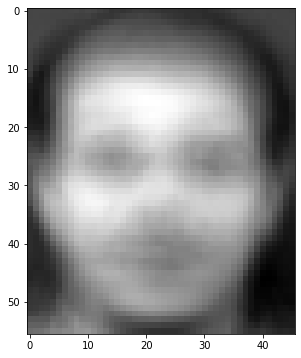

In [75]:
mean_image = np.mean(T, axis=0)
plt.figure(figsize=(8, 6))
plt.imshow(mean_image, cmap="gray")
plt.show()

We can then compute eigenvectors on the covariance matrix computed from $\hat{X}$. The PCA vectors would correspond to the eigenvectors, $\vec{v}$. In other words

\begin{aligned}
\Sigma \vec{v} = \lambda \vec{v}
\end{aligned}

However, as learned in class, if we compute the covariance matrix, we would need a lot of space to store it.

## T12

What is the size of the covariance matrix? What is the rank of the
covariance matrix?

In [76]:
# Train data has 3 images for each person, 40 people
X = T.reshape(120, -1).T
X_hat = X - mean_image.reshape(-1, 1)
cov = np.cov(X)
print("COV SIZE:", cov.shape)
print("COV RANK:", np.linalg.matrix_rank(cov))

COV SIZE: (2576, 2576)
COV RANK: 119


The trick we learned in class is to compute the Gram Matrix ($\hat{X}^T\hat{X}$), which is the inner product between the input matrices.

## T13

What is the size of the Gram matrix? What is the rank of Gram
matrix? If we compute the eigenvalues from the Gram matrix, how many non-zero eigenvalues do we expect to get?

In [77]:
gram = X_hat.T.dot(X_hat)
print("GRAM SIZE:", gram.shape)
print("GRAM RANK:", np.linalg.matrix_rank(gram))
print("GRAM non-zero eigenvalues:", (np.linalg.eigvals(gram) > 1e-6).sum())

GRAM SIZE: (120, 120)
GRAM RANK: 119
GRAM non-zero eigenvalues: 119


## T14

Is the Gram matrix also symmetric? Why?

## Answer

Gram Matrix เป็น symmetric matrix เพราะ $G = \hat{X^T}\hat{X}$ ซึ่งเมื่อลอง กระจายจะได้ว่า 

\begin{aligned}
G = 
\begin{bmatrix}
x_{0,0}x_{0,0} & x_{0,1}x_{1,0} & ... \\
x_{1,0}x_{0,1} & x_{1,1}x_{1,1} & ... \\
... & ... & ...
\end{bmatrix}
\end{aligned}

ซึ่งทำให้ $G = G^T$ หรือ Gram Matrix เป็น symmetric matrix

Using the gram matrix, we instead solve for the eigenvector, $\vec{v^{'}}$

\begin{aligned}
\hat{X^T}\hat{X}\vec{v^{'}} = \lambda\vec{v^{'}}
\end{aligned}

where the desired eigenvector (eigenvector of the covariance matrix) can be computed from $\vec{v^{'}}$ (eigenvector of the gram matrix) using the following relationship

\begin{aligned}
\vec{v} = \hat{X}\vec{v^{'}}
\end{aligned}

In order to compute the eigenvectors and eigenvalues, we can use the function `numpy.linalg.eigh` which can be used on symmetric matrices. For symmetric matrices, the eigenvectors and eigenvalues will always be real. In contrast, if the matrix is not symmetric, we have to use the function `numpy.linalg.eig` which will output complex numbers.


## T15

Compute the eigenvectors and eigenvalues of the Gram matrix, $\vec{v^{'}}$
and λ. Sort the eigenvalues and eigenvectors in descending order so that the first eigenvalue is the highest, and the first eigenvector corresponds to the best direction. How many non-zero eigenvalues are there? If you see a very small value, it is just numerical error and should be treated as zero.


In [78]:
eigenvalues, eigenvectors = np.linalg.eigh(gram)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
evalues = eigenvalues[eigenvalues > 1e-6]
evectors = eigenvectors[:,eigenvalues > 1e-6]
print("EVALUES SIZE:", evalues.shape)
print("EVECTORS SIZE:", evectors.shape)
print("FIRST EVALUE:", evalues[0])
print("FIRST EVECTOR:", evectors[:,0].shape)

EVALUES SIZE: (119,)
EVECTORS SIZE: (120, 119)
FIRST EVALUE: 1423.9297148381545
FIRST EVECTOR: (120,)


## T16

Plot the eigenvalues. Observe how fast the eigenvalues decrease.
In class, we learned that the eigenvalues is the size of the variance for each eigenvector direction. If I want to keep 95% of the variance in the data, how many eigenvectors should I use?

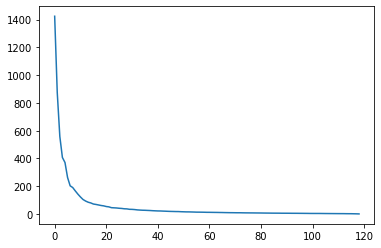

Amount of eigenvalues: 64
VAR: 0.9514558774601826


In [79]:
plt.plot(evalues)
plt.show()

eigen_amount = 64
variance = np.sum(evalues[0:eigen_amount])
print("Amount of eigenvalues:", eigen_amount)
print("VAR:", variance/np.sum(evalues))

(2576, 120)


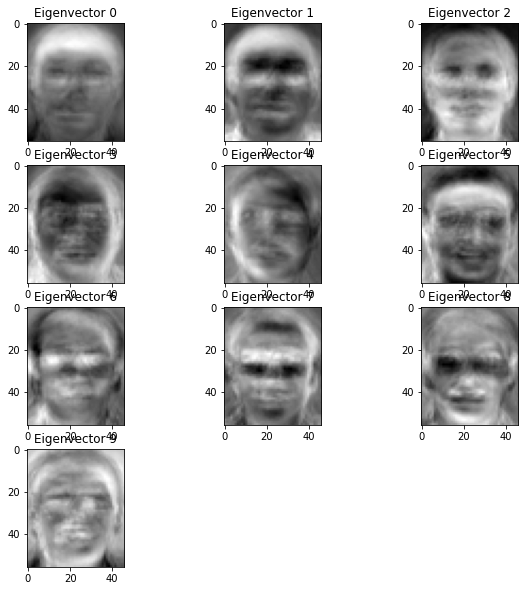

In [80]:
v = []
print(X_hat.shape)
for evec in evectors.T:
  v.append(np.dot(X_hat, evec))
v = np.array(v) / np.linalg.norm(v, axis=1).reshape(-1, 1)
# Get First eigen vectors

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
fig.delaxes(axs[3][1])
fig.delaxes(axs[3][2])

for i in range(10):
  axs[i//3][i%3].set_title("Eigenvector {}".format(i))
  axs[i//3][i%3].imshow(v[i].reshape(T[0].shape), cmap="gray")
plt.show()

## T18

From the image, what do you think the first eigenvector captures?
What about the second eigenvector? Look at the original images, do you think biggest variance are capture in these two eigenvectors?

## Answer

Eigen vector แรกจะเห็นสีขาวบริเวณโครงหน้า กับ ส่วนที่เป็นคอ ซึ่งก็คือส่วนที่บอกควมแตกต่างได้มากที่สุด

Eigen vector ที่สองจะ capture ไปที่บริเวณโครงหน้าและฟัน

**PCA subspace and the face verification system**

These eigenfaces we computed serve as good directions to project our data onto in order to decrease the number of dimensions. Since we have shown in class that these eigenvectors are orthogonal (and we normalized them so that they are orthonormal), we can find the projection, $\vec{p}$, of the data onto the eigenface subspace by

\begin{aligned}
\vec{p} = V^T(\vec{x}-\vec{\mu_x})
\end{aligned}

where V is a matrix whose columns are the eigenvectors, $\vec{v}$. The projection values, $\vec{p}$, will serve as our new input features.

## T19

Find the projection values of all images. Keep the first k = 10
projection values. Repeat the simple face verification system we did earlier using these projected values. What is the EER and the recall rate at 0.1% FAR?

In [108]:
V = v.T
TD = np.vstack((T, D))
x = TD.reshape(TD.shape[0], -1)
mu = mean_image.reshape(-1)
p = []
for i in range(x.shape[0]):
  p.append(V.T.dot(x[i] - mu))
p = np.array(p)
p.shape


(400, 119)

In [119]:
def face_verification(p, k=10):
  pt = p[:120,:k]
  pd = p[120:,:k]
  c = ConfusionMatrix(pt, pd, 3, 7)
  infos = c.find_infos()
  fprs = np.array([info["false_positive_rate"] for info in infos])
  fnrs = np.array([info["false_negative_rate"] for info in infos])
  index = np.argmin(np.abs(fprs - fnrs))
  eer = fprs[index]
  return eer

eer = face_verification(p ,10)
print("EER:", eer)

EER: 0.07884615384615384


## T20

What is the k that gives the best EER? Try k = 5,6,7,8,9,10,11,12,13,14.


In [120]:
for i in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
  eer = face_verification(p, i)
  print(f"EER (k={i}): {eer} ")


EER (k=5): 0.10705128205128205 
EER (k=6): 0.09413919413919414 
EER (k=7): 0.09276556776556777 
EER (k=8): 0.0858058608058608 
EER (k=9): 0.08021978021978023 
EER (k=10): 0.07884615384615384 
EER (k=11): 0.0782967032967033 
EER (k=12): 0.0848901098901099 
EER (k=13): 0.0815934065934066 
EER (k=14): 0.0826007326007326 


## Answer 

K that give the best EER is 11

**(Optional) PCA reconstruction**

One of the usage for PCA is compression. Using the project values, we can reconstruct the original image. This can be done by

\begin{aligned}
\vec{x^{'}} &= \vec{\mu_x}+\Sigma_kp_k\vec{v_k} \\
\vec{x^{'}} &= \vec{\mu_x} + V\vec{p}
\end{aligned}

where $\vec{x^{'}}$ is the reconstructed image.

We can compute the error from such reconstruction by computing the Mean Square Error (MSE)

\begin{aligned}
MSE = \Sigma_{i=1}^N\frac{1}{N}(x_i-x_i^{'})^2
\end{aligned}

where N is the dimension of the original input

## OT1 

Reconstruct the first image using this procedure. Use k = 10, what
is the MSE?

MSE 0.006148335016488305


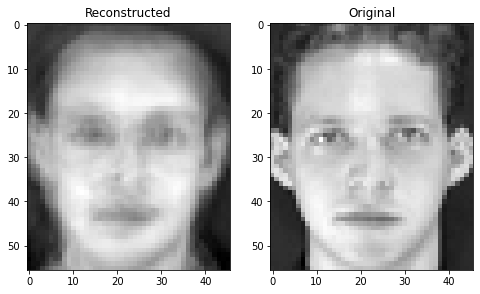

In [163]:
def recontruct_image(mu, V, p, k=10):
  p = p[:120,:k].T
  p = V[:,:k].dot(p)
  p = p + mu.reshape(-1, 1)
  return p.T
def MSE(x, xd):
  return np.mean((x - xd)**2)

x = recontruct_image(mu, V, p, 10).reshape(T.shape)
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
axes[0].set_title("Reconstructed")
axes[0].imshow(x[0], cmap="gray")
axes[1].set_title("Original")
axes[1].imshow(T[0], cmap="gray")
print("MSE", MSE(x[0], T[0]))
plt.show()

## OT2

For k values of 1,2,3,...,10, 119, show the reconstructed images. Plot the MSE values.

MSE (k=1) 0.018486954509692028
MSE (k=2) 0.016232644731309896
MSE (k=3) 0.010083926809950053
MSE (k=4) 0.010083926132523669
MSE (k=5) 0.010061224016363009
MSE (k=6) 0.009344143686155576
MSE (k=7) 0.008871378021262763
MSE (k=8) 0.008254991781399039
MSE (k=9) 0.006398962168451565
MSE (k=10) 0.006148335016488305
MSE (k=11) 0.006131073525169912
MSE (k=12) 0.006131067185509986
MSE (k=13) 0.00612258125644648
MSE (k=14) 0.0059827448477817275
MSE (k=15) 0.005504436650422388
MSE (k=16) 0.00548080676902432
MSE (k=17) 0.005463413981611269
MSE (k=18) 0.005431372856381862
MSE (k=19) 0.005417140497350821
MSE (k=20) 0.005280632308734927
MSE (k=21) 0.005236184620240872
MSE (k=22) 0.005093705485875719
MSE (k=23) 0.0049350263064635415
MSE (k=24) 0.004834832539287256
MSE (k=25) 0.004684370125379048
MSE (k=26) 0.004308236202968871
MSE (k=27) 0.0038380216345364174
MSE (k=28) 0.0038356250177574956
MSE (k=29) 0.0036838062328225516
MSE (k=30) 0.0036834288625417796
MSE (k=31) 0.003682405708658617
MSE (k=32) 0.

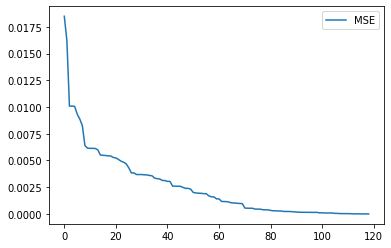

In [173]:
mses = []
for i in range(1, 120):
  x = recontruct_image(mu, V, p, i).reshape(T.shape)
  mse = MSE(x[0], T[0])
  mses.append(mse)
  print(f"MSE (k={i})", mse)
  # fig, axes = plt.subplots(ncols=2, figsize=(4, 4))
  # axes[0].set_title(f"Reconstructed (k={i})")
  # axes[0].imshow(x[0], cmap="gray")
  # axes[1].set_title(f"Original (k={i})")
  # axes[1].imshow(T[0], cmap="gray")
  # plt.show()
  
plt.plot(mses, label="MSE")
plt.legend()
plt.show()

## OT3

Consider if we want to store 1,000,000 images of this type. How
much space do we need? If we would like to compress the database by using the first 10 eigenvalues, how much space do we need? (Assume we keep the projection values, the eigenfaces, and the meanface as 32bit floats)

## Answer

**Linear Discriminant Analysis (LDA)**

We learned in class that PCA serves well in terms of lowering the dimensionality of the data. However, it does not aim to maximize the classification accuracy. PCA actually aims to retain the most information in the lowest possible subspace (as shown from our reconstruction experiment). PCA is also an unsupervised algorithm. We did not use any class information when we compute for PCA. On the other hand, LDA takes the class labels as inputs and aim to find the projection that maximize the separability between the classes.

LDA is usually used in conjunction with PCA. We first project using PCA to a lower dimensionality then use LDA to project to a subspace that better separates the class.

Assuming everything is already in the PCA subspace, to find the LDA projections, we first need to find the between class scatter, SB, and the within class scatter, SW . Between class scatter represents the spread between two classes. In class, for the two class example, it is defined as the distance between the means of class 1 and class 2 as shown below

\begin{aligned}
S_B = (\vec{\mu_1}-\vec{\mu_2})(\vec{\mu_1}-\vec{\mu_2})^T
\end{aligned}

n a multi-class setting, it is defined as the distance of the mean of each class with the global mean, $\mu$:

\begin{aligned}
S_B = \Sigma_{i=1}^{N_c}(\vec{\mu_i}-\vec{\mu})(\vec{\mu_i}-\vec{\mu})^T
\end{aligned}

where $N_c$ is the number of classes.

$S_W$ represents the scatter within each class. For a class $i$, we can compute the scatter of the class by

\begin{aligned}
S_{W_i} = \Sigma_{j=1}^{N_i}(\vec{x_j}-\vec{\mu_i})(\vec{x_j}-\vec{\mu_i})^T
\end{aligned}

where Ni is the number of data in class i, $\vec{x_j}$ is the jth data sample from class i (in the PCA subspace).

The total within class scatter, SW , can then be computed by

\begin{aligned}
S_W = \Sigma_{i=1^{N_c}}\Sigma_{j=1}^{N_i}(\vec{x_j}-\vec{\mu_i})(\vec{x_j}-\vec{\mu_i})^T
\end{aligned}

To find the LDA projection, we want to find a projection, $\vec{x_j}$, that maximizes $S_B$, but minimizes $S_W$ . To do so, we maximize the ratio (the Fisher criterion)

\begin{aligned}
\frac{\vec{w^TS_B\vec{w}}}{\vec{w^TS_W\vec{w}}}
\end{aligned}

After some calculus, the solution to this maximization is in the form

\begin{aligned}
S_B\vec{w} = \lambda S_W\vec{w}
\end{aligned}

If we assume, $S_W$ is invertible. This becomes

\begin{aligned}
S_W^{-1}S_B\vec{w} = \lambda\vec{w}
\end{aligned}

In other words, the LDA projections are the eigenvectors of $S^{−1}
_W S_B$.

## T21

n order to assure that $S_W$ is invertible we need to make sure that
$S_W$ is full rank. How many PCA dimensions do we need to keep in order for SW to be full rank? (Hint: How many dimensions does SW have? In order to be of full rank, you need to have the same number of linearly independent factors)


## T22

Using the answer to the previous question, project the original in-
put to the PCA subspace. Find the LDA projections. To find the inverse, use numpy.linalg.inv. Is $S^{−1}_W SB$ symmetric? Can we still use `numpy.linalg.eigh`? How many non-zero eigenvalues are there?

## T23

Plot the first 10 LDA eigenvectors as images (the 10 best projections). Note that in this setup, you need to convert back to the original image space by using the PCA projection. The LDA eigenvectors can be considered as a linear combination of eigenfaces. Compare the LDA projections with the PCA
projections

## T24

The combined PCA+LDA projection procedure is called fisherface.
Calculate the fisherfaces projection of all images. Do the simple face verification experiment using fisherfaces. What is the EER and recall rate at 0.1% FAR?

## T25

Plot the RoC of all three experiments (No projection, PCA, and
Fisher) on the same axes. Compare and contrast the three results. Submit your writeup and code on MyCourseVille.

## OT4

Plot the first two LDA dimensions of the test images from different
people (6 people 7 images each). Use a different color for each person. Observe the clustering of between each person. Repeat the same steps for the PCA projections. Does it come out as expected?
